In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
import numpy as np
import pandas as pd

In [4]:
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import and_, or_, not_

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [29]:
###Delete This Cell
#debug code
inspector = inspect(engine)

# inspector.get_table_names()

print ("---measurement---")
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
    
print ("---station---")
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

# session.query(func.count(Measurement.date)).all()
# session.query(func.count(Station.date)).all()

# session.query(Measurement.id, Measurement.station , Measurement.date, Measurement.prcp, Measurement.tobs ).\
#     order_by(Measurement.date.desc()).all()

---measurement---
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
---station---
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

#query the date of last data point
last_date_query = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()

#transform date into datetime
last_date = datetime.strptime(last_date_query[0], '%Y-%m-%d')

#calculate query date
#to include the end points, use 366 days.
query_date = last_date - timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
last_12months = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > query_date).\
    order_by(Measurement.date).all()

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df_prcp = pd.DataFrame(last_12months, columns=['date', 'prcp']).set_index('date')
df_prcp = df_prcp.sort_values('date')

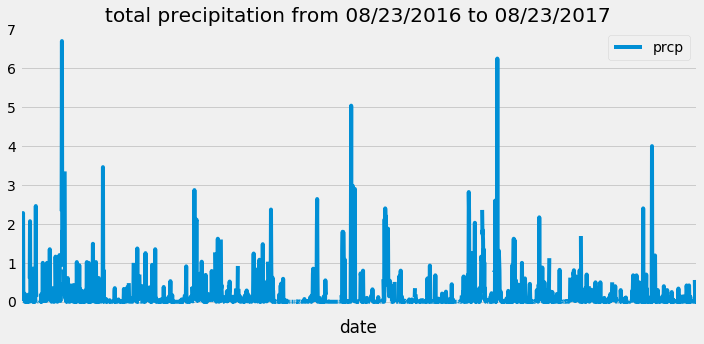

<Figure size 432x288 with 0 Axes>

In [15]:
### Discuss with TA - do I need to figure out how to make the xticks appear properly? It does not show up on the solution.

# Use Pandas Plotting with Matplotlib to plot the data
df_prcp.plot(figsize = (10,5), title = "total precipitation from 08/23/2016 to 08/23/2017", grid = True, xticks=[])
plt.tight_layout()
plt.show()
plt.savefig("Outputs/Total Precipitation (1).png")

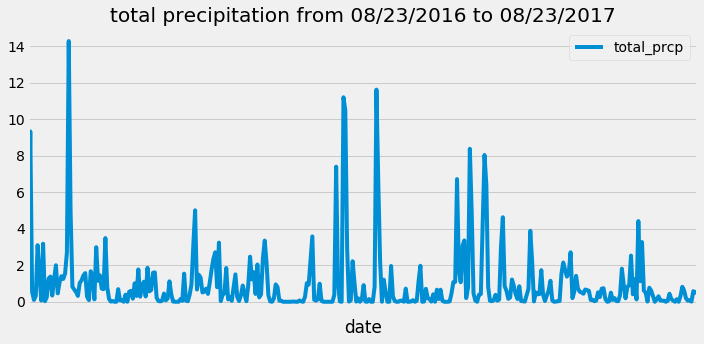

<Figure size 432x288 with 0 Axes>

In [16]:
### Discuss with TA - groupby or not?

#group by dates
tot_prcp = df_prcp.groupby('date')['prcp'].sum()
groupd_df = pd.DataFrame({"total_prcp": tot_prcp})
# Sort the dataframe by date
groupd_df = groupd_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
groupd_df.plot(figsize = (10,5), title = "total precipitation from 08/23/2016 to 08/23/2017", grid = True, xticks=[])
plt.tight_layout()
plt.show()
plt.savefig("Outputs/Total Precipitation (2).png")

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_prcp.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [18]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(Station.station).count()
number_of_stations

9

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_station = station_activity[0][0]
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

m_active_stats = session.query(*sel).\
    filter(Measurement.station == most_active_station).all()

m_active_stats


[(54.0, 85.0, 71.66378066378067)]

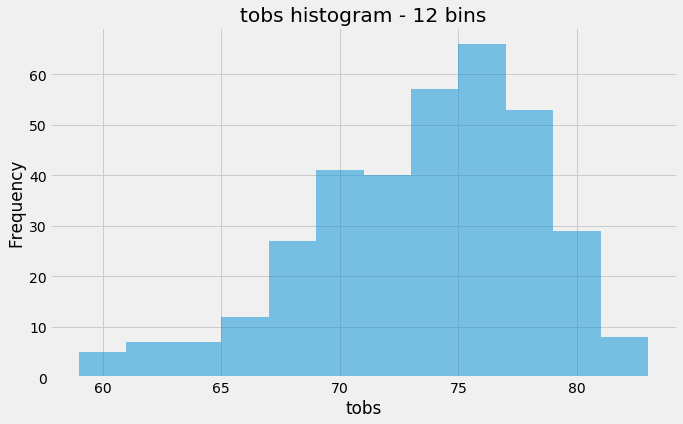

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
activestation_12months = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.date > query_date).\
    filter(Measurement.station == most_active_station).all()

df_station = pd.DataFrame(activestation_12months, columns=['station', 'date', 'tobs'])

plt.figure(figsize = (10,6))
plt.title("tobs histogram - 12 bins")
plt.xlabel('tobs')
df_station["tobs"].plot.hist(bins = 12, alpha = 0.5)
plt.savefig("Outputs/Tobs Histogram.png")

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [32]:
###Discuss with TA - the solutions show a different output: 62.0 68.36585365853658 74.0
###Therefore, the chart also looks slightly different
###But also, the solution chart does not reflect its output... it looks like the avg temperature is above 70.

# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2012-02-28'
end_date = '2012-03-05'

sel2 = [func.min(Measurement.tobs), 
       func.avg(Measurement.tobs),
       func.max(Measurement.tobs)]

mycalc_temps = session.query(*sel2).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).all()
mycalc_temps

[(62.0, 69.57142857142857, 74.0)]

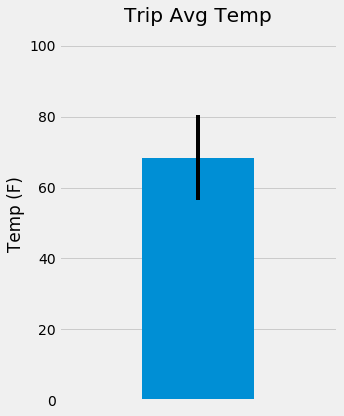

<Figure size 432x288 with 0 Axes>

In [27]:
df_mycalc_temps = pd.DataFrame(mycalc_temps, columns = ['min', 'avg', 'max'])
# df_mycalc_temps = df_mycalc_temps.T
df_mycalc_temps

# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

err = df_mycalc_temps['max']- df_mycalc_temps['min']

plt.figure(figsize=(5,6))
plt.bar(1, df_mycalc_temps['avg'], yerr = err)
plt.xlim(0,2)
plt.xticks ([],[])
plt.ylim(0,105)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')

plt.tight_layout()
plt.show()
plt.savefig("Outputs/Trip Avg Temp.png")

## Optional Challenge Assignment

In [19]:
### Where is the trip date relevant? Is it for this section? 
### But this section of the notebook is considered bonus...
### * Choose a start date and end date for your trip. Make sure that your vacation range is approximately 3-15 days total.

# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
## Start Here
start_date = '2016-08-09' 
end_date = '2016-08-12' 

query_start_date = start_date - timedelta(days=366)
query_end_date = end_date - timedelta(days=366)

##need to perform a merge.

# Perform a query to retrieve the data and precipitation scores



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


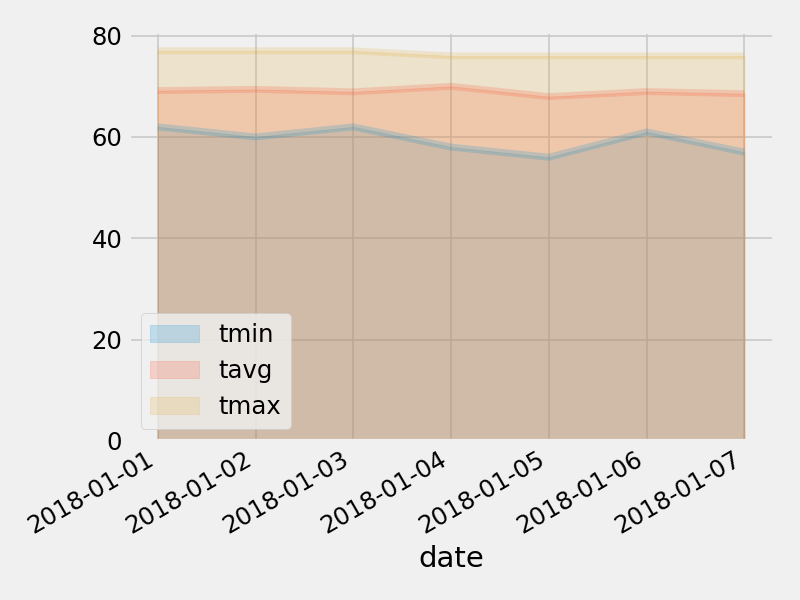

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
